Dataset : https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import random

In [76]:
# ucf11 mpg 파일의 개수
print(len(glob('UCF11_updated_mpg/*/*/*.mpg')))

1600


In [77]:
file_paths = glob('UCF11_updated_mpg/*/*/*.mpg')

In [78]:
file_paths[0]

'UCF11_updated_mpg/volleyball_spiking/v_spiking_12/v_spiking_12_04.mpg'

In [79]:
# cv2.VideoCapture 동영상
cap = cv2.VideoCapture(file_paths[0]) # 5초짜리 영상

frames = []

while True :
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.resize(frame, (256, 256))
    frame = frame[:, :, [2, 1, 0]] # BGR(0, 1, 2) -> RGB
    frames.append(frame)
    
cap.release()

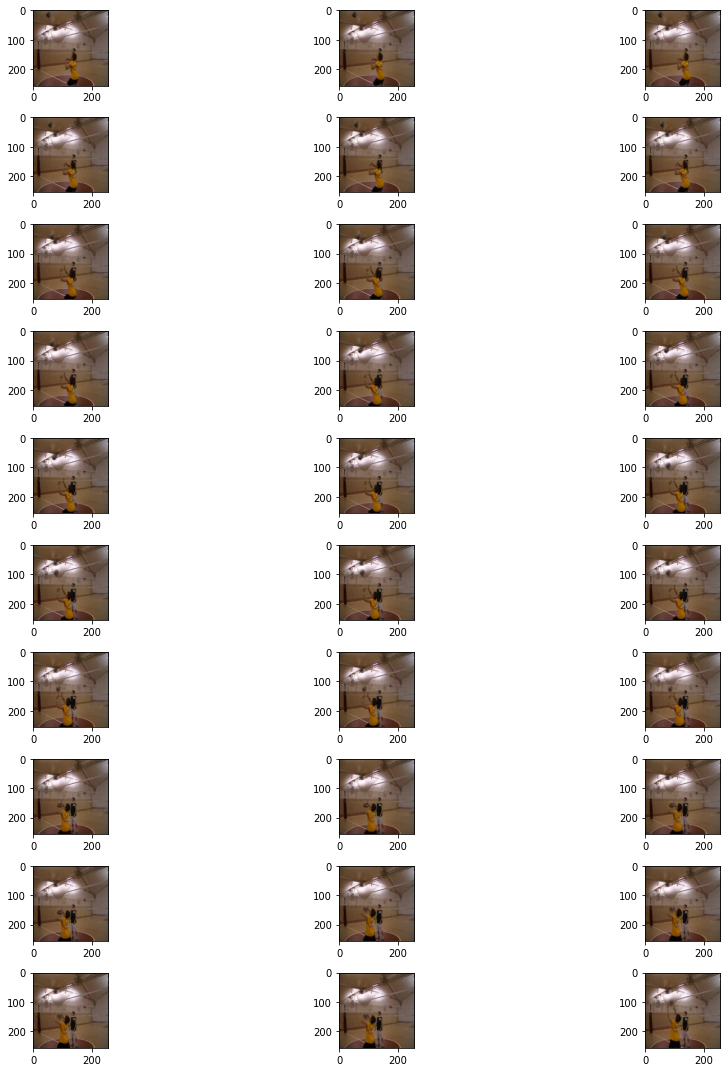

In [80]:
arr = np.array(frames)
plt.figure(figsize=(15, 15))

for i in range(10):            # i=0         i=1
    plt.subplot(10, 3, 1 + 3*i)#10, 3, 1     10, 3, 4
    plt.imshow(arr[1 + 3 * i]) # arr[1]
    
    plt.subplot(10, 3, 2 + 3*i) #10, 3, 2    10, 3, 5
    plt.imshow(arr[2 + 3 * i]) #arr[2]
    
    plt.subplot(10, 3, 3 + 3*i) #10, 3, 3    10, 3, 6
    plt.imshow(arr[3 + 3 * i]) #arr[3]
    
plt.tight_layout()

In [81]:
df = pd.DataFrame(columns=['file_path', 'frames', 'duration', 'label'])

for file_path in file_paths :
    label = file_path.split('/')[1]
    cap = cv2.VideoCapture(file_path)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frames / 29.97
    
    elem = {
        'file_path' : file_path,
        'frames' : frames,
        'duration' : duration,
        'label' : label
    }
    df.loc[len(df)] = elem
    cap.release()

In [82]:
file_paths[0]

'UCF11_updated_mpg/volleyball_spiking/v_spiking_12/v_spiking_12_04.mpg'

In [83]:
df

,file_path,frames,duration,label
0,UCF11_updated_mpg/volleyball_spiking/v_spiking...,137,4.571238,volleyball_spiking
1,UCF11_updated_mpg/volleyball_spiking/v_spiking...,101,3.370037,volleyball_spiking
2,UCF11_updated_mpg/volleyball_spiking/v_spiking...,62,2.068735,volleyball_spiking
3,UCF11_updated_mpg/volleyball_spiking/v_spiking...,115,3.837171,volleyball_spiking
4,UCF11_updated_mpg/volleyball_spiking/v_spiking...,86,2.869536,volleyball_spiking
...,...,...,...,...
1595,UCF11_updated_mpg/diving/v_diving_08/v_diving_...,155,5.171839,diving
1596,UCF11_updated_mpg/diving/v_diving_08/v_diving_...,145,4.838172,diving
1597,UCF11_updated_mpg/diving/v_diving_08/v_diving_...,168,5.605606,diving
1598,UCF11_updated_mpg/diving/v_diving_08/v_diving_...,158,5.271939,diving


In [84]:
# label별 group을 맺어 각 그륩의 영상의 길이를 출력
# label, sum(영상길이)
# basketball 639.139139

# label, average(평균 영상 길이)
# basketball 4.532902

In [85]:
df_duration_sum_label = df.groupby('label').duration.sum().rename('sum')
df_duration_sum_label

label
basketball             639.139139
biking                1094.060727
diving                 891.157824
golf_swing             786.586587
horse_riding          1296.429763
soccer_juggling       1522.655989
swing                  921.588255
tennis_swing           883.416750
trampoline_jumping     799.799800
volleyball_spiking     428.128128
walking                921.121121
Name: sum, dtype: float64

In [86]:
# label, average(평균 영상 길이)
# basketball 4.532902

In [87]:
df_duration_avg_label = df.groupby('label').duration.mean().rename('Average')
df_duration_avg_label

label
basketball            4.532902
biking                7.545246
diving                5.712550
golf_swing            5.539342
horse_riding          6.547625
soccer_juggling       9.760615
swing                 6.726922
tennis_swing          5.289921
trampoline_jumping    6.721007
volleyball_spiking    3.690760
walking               7.488790
Name: Average, dtype: float64

<AxesSubplot:xlabel='label'>

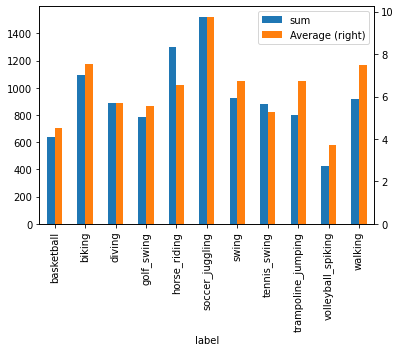

In [88]:
df_video_states = pd.concat([df_duration_sum_label, df_duration_avg_label], axis=1)
df_video_states.plot.bar(secondary_y='Average')

In [89]:
label_dir = glob('UCF11_updated_mpg/*')
label_dir

['UCF11_updated_mpg/volleyball_spiking',
 'UCF11_updated_mpg/golf_swing',
 'UCF11_updated_mpg/swing',
 'UCF11_updated_mpg/tennis_swing',
 'UCF11_updated_mpg/soccer_juggling',
 'UCF11_updated_mpg/horse_riding',
 'UCF11_updated_mpg/walking',
 'UCF11_updated_mpg/basketball',
 'UCF11_updated_mpg/trampoline_jumping',
 'UCF11_updated_mpg/biking',
 'UCF11_updated_mpg/diving']

In [90]:
# 11개의 클래스
# 클래스당 25개의 영상 그룹
# 0 ~ 19 : 학습 그룹
# 20 ~ 24 : 테스트 그룹

train_df = pd.DataFrame(
    columns = ['file_path', 'label']
)

valid_df = pd.DataFrame(
    columns = ['file_path', 'label']
)

label_dirs = glob('UCF11_updated_mpg/*')

for label_dir in label_dirs: # UCF11_updated_mpg/volleyball_spiking

    file_dirs = glob(label_dir + '/v_*')
    random.shuffle(file_dirs)
    
    for i in range(20):
        train_dir = file_dirs[i]
        label = train_dir.split('/')[-1].split('_')[1]
        file_path = random.choice(glob(train_dir + '/*'))
        train_df.loc[len(train_df)] = [file_path, label]
    
    for i in range(20, 25):
        valid_dir = file_dirs[i]
        label = valid_dir.split('/')[-1].split('_')[1]
        file_path = random.choice(glob(train_dir + '/*'))
        valid_df.loc[len(valid_df)] = [file_path, label]

In [91]:
print(len(train_df))
print(len(valid_df))

220
55


In [92]:
import os

os.mkdir('UCF11_updated_png')
os.mkdir('UCF11_updated_png/train')
os.mkdir('UCF11_updated_png/valid')

FileExistsError: [Errno 17] File exists: 'UCF11_updated_png'

In [93]:
train_df.to_csv('ucf11_train_vid.csv', index=False)
valid_df.to_csv('ucf11_valid_vid.csv', index=False)

In [94]:
train_df

,file_path,label
0,UCF11_updated_mpg/volleyball_spiking/v_spiking...,spiking
1,UCF11_updated_mpg/volleyball_spiking/v_spiking...,spiking
2,UCF11_updated_mpg/volleyball_spiking/v_spiking...,spiking
3,UCF11_updated_mpg/volleyball_spiking/v_spiking...,spiking
4,UCF11_updated_mpg/volleyball_spiking/v_spiking...,spiking
...,...,...
215,UCF11_updated_mpg/diving/v_diving_13/v_diving_...,diving
216,UCF11_updated_mpg/diving/v_diving_08/v_diving_...,diving
217,UCF11_updated_mpg/diving/v_diving_22/v_diving_...,diving
218,UCF11_updated_mpg/diving/v_diving_23/v_diving_...,diving


In [95]:
max_frame = 10
SAVE_DIR = 'UCF11_updated_png/'

for i, elem in train_df.iterrows():
    cap = cv2.VideoCapture(
        elem['file_path']
    )
    
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            print('can not open')
            break
        
        frame = cv2.resize(frame, (256, 256))
        frames.append(frame)
        
        if len(frames) == max_frame:
            break
            
    label = elem['label']
    for j, frame in enumerate(frames):
        file_name = f'train/{label}_{i}_{j}.png'
        #print(SAVE_DIR+file_name)
        cv2.imwrite(SAVE_DIR + file_name, frame)
    
    cap.release()

In [96]:
max_frame = 10
SAVE_DIR = 'UCF11_updated_png/'

for i, elem in valid_df.iterrows():
    cap = cv2.VideoCapture(
        elem['file_path']
    )
    
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, (256, 256))
        frames.append(frame)
        
        if len(frames) == max_frame:
            break
            
    label = elem['label']
    for j, frame in enumerate(frames):
        file_name = f'valid/{label}_{i}_{j}.png'
        cv2.imwrite(SAVE_DIR + file_name, frame)
    
    cap.release()

In [97]:
print(len(glob(SAVE_DIR + 'train/*')))

2200


In [98]:
print(len(glob(SAVE_DIR + 'valid/*')))

550
